Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [1]:
from itertools import product, combinations
import numpy as np
import networkx as nx
from icecream import ic

In [2]:
def create_problem(
    size: int,
    *,
    # determines the sparsity, 
    # for every possible connection there is only a density% chance that a direct road exists
    density: float = 1.0,   
    negative_values: bool = False,
    noise_level: float = 0.0,
    seed: int = 42,
) -> np.ndarray:
    """Problem generator for Lab3"""
    rng = np.random.default_rng(seed)
    map = rng.random(size=(size, 2))
    problem = rng.random((size, size))
    if negative_values:
        problem = problem * 2 - 1
    problem *= noise_level
    for a, b in product(range(size), repeat=2):
        #check inside a loop over all pairs, directed graph.
        if rng.random() < density:
            # cost to travel between two nodes 
            problem[a, b] += np.sqrt(
                np.square(map[a, 0] - map[b, 0]) + np.square(map[a, 1] - map[b, 1])
            )
        else:
            problem[a, b] = np.inf
    np.fill_diagonal(problem, 0)
    return (problem * 1_000).round()

In [3]:
rng = np.random.default_rng(42)  # Same seed as create_problem
node_map = rng.random(size=(10, 2))  # Extract the positions
node_positions = {i: (node_map[i, 0], node_map[i, 1]) for i in range(10)}

problem = create_problem(10, density=0.15, noise_level=10, negative_values=False)
problem

array([[    0.,    inf, 10573.,    inf,  8430.,    inf,    inf,   831.,
         1977.,    inf],
       [   inf,     0.,    inf,    inf,    inf,  2434.,    inf,    inf,
           inf,  6771.],
       [   inf,    inf,     0.,    inf,    inf,    inf,    inf,    inf,
           inf,  2208.],
       [   inf,    inf,  8563.,     0.,  7768.,    inf,    inf,    inf,
           inf,    inf],
       [ 7330.,    inf,    inf,  8367.,     0.,    inf,    inf,    inf,
           inf,    inf],
       [   inf,    inf,    inf,    inf,    inf,     0.,    inf,    inf,
           inf,    inf],
       [   inf,    inf,    inf,    inf,    inf,    inf,     0.,  5247.,
           inf,    inf],
       [   inf,    inf,  5287.,    inf,    inf,    inf,    inf,     0.,
           inf,    inf],
       [   inf,    inf,    inf, 10443.,  8363.,    inf,  5258.,    inf,
            0.,    inf],
       [   inf,    inf,    inf,    inf,    inf,    inf,  7850.,  7752.,
           inf,     0.]])

In [4]:
# inf values are treated as non-existent edges.
masked = np.ma.masked_array(problem, mask=np.isinf(problem))
G = nx.from_numpy_array(masked, create_using=nx.DiGraph)

In [5]:
for s, d in combinations(range(problem.shape[0]), 2):
    try:
        # Dijkstra algorithm to find cheapest route
        path = nx.shortest_path(G, s, d, weight='weight')
        cost = cost = nx.path_weight(G, path, weight='weight')
    except nx.NetworkXNoPath:
        path = None
        cost = np.inf
    ic(s, d, path, cost)
None

ic| s: 0, d: 1, path: None, cost: inf
ic| s: 0, d: 2, path: [0, 7, 2], cost: 6118.0
ic| s: 0, d: 3, path: [0, 8, 3], cost: 12420.0
ic| s: 0, d: 4, path: [0, 4], cost: 8430.0
ic| s: 0, d: 5, path: None, cost: inf
ic| s: 0, d: 6, path: [0, 8, 6], cost: 7235.0
ic| s: 0, d: 7, path: [0, 7], cost: 831.0
ic| s: 0, d: 8, path: [0, 8], cost: 1977.0
ic| s: 0, d: 9, path: [0, 7, 2, 9], cost: 8326.0
ic| s: 1, d: 2, path: [1, 9, 7, 2], cost: 19810.0
ic| s: 1, d: 3, path: None, cost: inf
ic| s: 1, d: 4, path: None, cost: inf
ic| s: 1, d: 5, path: [1, 5], cost: 2434.0
ic| s: 1, d: 6, path: [1, 9, 6], cost: 14621.0
ic| s: 1, d: 7, path: [1, 9, 7], cost: 14523.0
ic| s: 1, d: 8, path: None, cost: inf
ic| s: 1, d: 9, path: [1, 9], cost: 6771.0
ic| s: 2, d: 3, path: None, cost: inf
ic| s: 2, d: 4, path: None, cost: inf
ic| s: 2, d: 5, path: None, cost: inf
ic| s: 2, d: 6, path: [2, 9, 6], cost: 10058.0
ic| s: 2, d: 7, path: [2, 9, 7], cost: 9960.0
ic| s: 2, d: 8, path: None, cost: inf
ic| s: 2, d: 9, pat

In [6]:
import logging
from queue import PriorityQueue

def dijkstra_search(
    graph,
    start,
    goal,
    parent_state,
    state_cost,
):
    """
    Dijkstra using professor's standard search() interface.
    priority = current state_cost
    unit_cost(a) returns the edge weight
    """

    # --------------------------
    # Required template functions
    # --------------------------
    
    def goal_test(state):
        return state == goal

    def possible_actions(state):
        return graph[state]  # NetworkX => adjacency dict of neighbors

    def result(state, action):
        return action  # Action is simply "which neighbor"

    def unit_cost(action):
        # graph[state][action] is dict -> {'weight': cost}
        return graph[state][action].get("weight", 1)

    def priority_function(state):
        return state_cost[state]  # Dijkstra priority = g(n)

    # --------------------------
    # Frontier with cost support
    # --------------------------
    class FrontierPQ:
        def __init__(self):
            self.pq = PriorityQueue()
            self.entry_map = {}  # state -> priority

        def push(self, state, p):
            self.entry_map[state] = p
            self.pq.put((p, state))

        def pop(self):
            # pop until we find a non-stale entry
            while not self.pq.empty():
                p, s = self.pq.get()
                if s in self.entry_map and self.entry_map[s] == p:
                    del self.entry_map[s]  # remove now
                    return s
            return None

        def __contains__(self, state):
            return state in self.entry_map

        def __bool__(self):
            return len(self.entry_map) > 0

    # --------------------------
    # Initialize
    # --------------------------
    frontier = FrontierPQ()
    parent_state.clear()
    state_cost.clear()

    state = start
    parent_state[state] = None
    state_cost[state] = 0
    frontier.push(state, p=priority_function(state))

    # --------------------------
    # Main loop
    # --------------------------
    while state is not None and not goal_test(state):
        for a in possible_actions(state):
            new_state = result(state, a)
            cost = unit_cost(a)
            new_g = state_cost[state] + cost

            # Case 1: not visited and not in frontier
            if new_state not in state_cost and new_state not in frontier:
                parent_state[new_state] = state
                state_cost[new_state] = new_g
                frontier.push(new_state, p=priority_function(new_state))

            # Case 2: in frontier with higher cost → decrease-key
            elif new_state in frontier and new_g < state_cost[new_state]:
                old_cost = state_cost[new_state]
                parent_state[new_state] = state
                state_cost[new_state] = new_g
                frontier.push(new_state, p=priority_function(new_state))  # update

        # Advance search
        if frontier:
            state = frontier.pop()
        else:
            state = None

    # --------------------------
    # Reconstruct path
    # --------------------------
    if state is None:
        return None, float("inf")

    path = []
    s = state
    while s is not None:
        path.append(s)
        s = parent_state[s]

    path.reverse()
    return path, state_cost[state]


In [7]:
def bellman_ford_search(
    graph,
    start,
    goal,
    parent_state,
    state_cost,
):
    """
    Bellman-Ford to handle negative weights.
    """

    # Initialize
    nodes = list(graph.nodes())
    for node in nodes:
        state_cost[node] = float("inf")
        parent_state[node] = None

    state_cost[start] = 0

    # Relax edges iterating through all nodes |V|-1 times
    for _ in range(len(nodes) - 1):
        changed = False
        for u in nodes:
            if state_cost[u] == float("inf"):
                continue
            # explore neighbors
            for v in graph[u]:
                weight = graph[u][v].get("weight", 1)
                if state_cost[u] + weight < state_cost[v]:
                    state_cost[v] = state_cost[u] + weight
                    parent_state[v] = u
                    changed = True
    
        # Early stopping if no changes
        if not changed:
            break
    
    # Check for negative-weight cycles
    for u in nodes:
        if state_cost[u] != float("inf"):
            for v in graph[u]:
                weight = graph[u][v].get("weight", 1)
                if state_cost[u] + weight < state_cost[v]:
                    raise ValueError("Graph contains a negative-weight cycle")
                
    # Reconstruct path
    if state_cost[goal] == float("inf"):
        return None, float("inf")
    
    path = []
    s = goal
    while s is not None:
        path.append(s)
        s = parent_state[s]
    path.reverse()
    return path, state_cost[goal]

In [8]:
import math
import heapq

def a_star_search(
    graph,
    start,
    goal,
    parent_state,
    state_cost,
    heuristic= None
):
    """
    priority = g(n) + h(n)
    """

    if heuristic is None:
        heuristic = lambda n, g: 0
    
    def goal_test(state):
        return state == goal

    def possible_actions(state):
        return graph[state]  # adjacency dict of neighbors

    def result(state, action):
        return action  # says "which neighbor"

    def unit_cost(u,v):
        # graph[state][action] is dict -> {'weight': cost}
        return graph[u][v].get("weight", 1)

    def priority_function(state, current_g):
        return current_g + heuristic(state, goal)  # A* priority = g(n) + h(n)

    # Frontier with cost support
    class FrontierPQ:
        def __init__(self):
            self.pq = []
            self.entry_map = {}  # state -> priority
            self.counter = 0  # unique sequence count

        def push(self, state, p):
            self.entry_map[state] = p
            heapq.heappush(self.pq, (p, self.counter, state))
            self.counter += 1

        def pop(self):
            # pop until we find a non-stale entry
            while self.pq:
                p, _, s = heapq.heappop(self.pq)
                if s in self.entry_map and self.entry_map[s] == p:
                    del self.entry_map[s]
                    return s
            return None

        def __contains__(self, state):
            return state in self.entry_map

        def __bool__(self):
            return len(self.entry_map) > 0

    # Initialize
    frontier = FrontierPQ()
    parent_state.clear()
    state_cost.clear()

    parent_state[start] = None
    state_cost[start] = 0
    f_score = state_cost[start] + heuristic(start, goal)
    frontier.push(start, f_score)

    # --------------------------
    # Main loop
    # --------------------------
    while frontier:
        state = frontier.pop()
        
        if state is None: # Handle empty/stale queue
            break

        if goal_test(state): # Move goal test here for efficiency
            # Reconstruct path immediately
            path = []
            s = state
            while s is not None:
                path.append(s)
                s = parent_state[s]
            path.reverse()
            return path, state_cost[state]

        for neighbor in graph[state]:
            cost = graph[state][neighbor].get("weight", 1)
            new_g = state_cost[state] + cost

            if neighbor not in state_cost or new_g < state_cost[neighbor]:
                parent_state[neighbor] = state
                state_cost[neighbor] = new_g
                f_score = new_g + heuristic(neighbor, goal)
                frontier.push(neighbor, f_score)
    
    return None, float("inf")
"""       

        for a in possible_actions(state):
            new_state = result(state, a)
            cost = unit_cost(state,a)
            new_g = state_cost[state] + cost

            # Case 1: not visited and not in frontier
            if new_state not in state_cost or new_g < state_cost[new_state]:
                parent_state[new_state] = state
                state_cost[new_state] = new_g
                frontier.push(new_state, p=priority_function(new_state, new_g))
            
            
            # Case 2: in frontier with higher cost → decrease-key
            elif new_state in frontier and new_g < state_cost[new_state]:
                old_cost = state_cost[new_state]
                parent_state[new_state] = state
                state_cost[new_state] = new_g
                frontier.push(new_state, p=priority_function(new_state, new_g))  # update
        
        # Advance search
        if frontier:
            state = frontier.pop()
        else:
            state = None
        
    # Reconstruct path
    if state is None:
        return None, float("inf")   
    
    path = []
    s = state   
    while s is not None:
        path.append(s)
        s = parent_state[s]
    path.reverse()
    return path, state_cost[state]
    """


        

'       \n\n        for a in possible_actions(state):\n            new_state = result(state, a)\n            cost = unit_cost(state,a)\n            new_g = state_cost[state] + cost\n\n            # Case 1: not visited and not in frontier\n            if new_state not in state_cost or new_g < state_cost[new_state]:\n                parent_state[new_state] = state\n                state_cost[new_state] = new_g\n                frontier.push(new_state, p=priority_function(new_state, new_g))\n            \n            \n            # Case 2: in frontier with higher cost → decrease-key\n            elif new_state in frontier and new_g < state_cost[new_state]:\n                old_cost = state_cost[new_state]\n                parent_state[new_state] = state\n                state_cost[new_state] = new_g\n                frontier.push(new_state, p=priority_function(new_state, new_g))  # update\n        \n        # Advance search\n        if frontier:\n            state = frontier.pop()\n     

In [9]:
def dfs_search(
    graph,
    start,
    goal,
    parent_state,
    state_cost,
):
    """
    Depth-First Search implementation.
    """

    
    def goal_test(state):
        return state == goal
    def possible_actions(state):
        return graph[state]  # adjacency dict of neighbors
    def result(state, action):
        return action  # says "which neighbor"  
    
    class FrontierStack:
        def __init__(self):
            self.stack = []
            self.visited = set() # Optimization for graph search

        def push(self, state, p=0): 
            self.stack.append(state)

        def pop(self):
            return self.stack.pop() if self.stack else None
        
        def __bool__(self): return len(self.stack) > 0

    # Initialize
    frontier = FrontierStack()
    parent_state.clear()
    state_cost.clear()
    
    parent_state[start] = None
    state_cost[start] = 0
    frontier.push(start)

    visited = set()  # To keep track of visited nodes

    state = frontier.pop()

    while state is not None:
        if goal_test(state):
            break

        if state not in visited:
            visited.add(state)

            neighbors = list(graph[state])

            for a in neighbors:
                if a not in visited:
                    parent_state[a] = state
                    state_cost[a] = state_cost[state] + graph[state][a].get("weight", 1)
                    frontier.push(a)
        if frontier:
            state = frontier.pop()
        else:
            state = None
    
    # Reconstruct path 
    if state is None:
        return None, float("inf")  
    path = []
    s = state
    while s is not None:
        path.append(s)
        s = parent_state[s]
    path.reverse()
    return path, state_cost[state]


In [10]:
# 1. Define a simple heuristic for A* (Zero makes it behave like Dijkstra)
def zero_heuristic(state, goal):
    return 0
def euclidean_heuristic(node_positions):
    """Euclidean distance between nodes (admissible for spatial graphs)
    
    Args:
        node_positions: dict mapping node_id -> (x, y) coordinates
    Returns:
        heuristic function
    """
    def heuristic(state, goal):
        x1, y1 = node_positions[state]
        x2, y2 = node_positions[goal]
        return np.sqrt((x2 - x1)**2 + (y2 - y1)**2) * 1000  # Scale to match edge weights
    return heuristic

def manhattan_heuristic(node_positions):
    """Manhattan distance (admissible, faster to compute than Euclidean)
    
    Args:
        node_positions: dict mapping node_id -> (x, y) coordinates
    Returns:
        heuristic function
    """
    def heuristic(state, goal):
        x1, y1 = node_positions[state]
        x2, y2 = node_positions[goal]
        return (abs(x2 - x1) + abs(y2 - y1)) * 1000
    return heuristic

print(f"{'Algo':<15} | {'Path':<25} | {'Cost':<10} | {'Match (vs NX)':<10}")
print("-" * 70)

for s, d in combinations(range(problem.shape[0]), 2):
    # --- 1. Ground Truth (NetworkX) ---
    try:
        nx_path = nx.shortest_path(G, s, d, weight='weight')
        nx_cost = nx.path_weight(G, nx_path, weight='weight')
    except nx.NetworkXNoPath:
        nx_path = None
        nx_cost = float('inf')

    print(f"\n--- Path {s} -> {d} ---")
    print(f"{'NetworkX':<15} | {str(nx_path):<25} | {nx_cost:<10.2f} | N/A")

    # --- 2. Dijkstra ---
    parent_state = {}
    state_cost = {}
    d_path, d_cost = dijkstra_search(G, s, d, parent_state, state_cost)
    is_match = (d_cost == nx_cost)
    print(f"{'Dijkstra':<15} | {str(d_path):<25} | {d_cost:<10.2f} | {is_match}")

    # --- 3. Bellman-Ford ---
    parent_state = {}
    state_cost = {}
    bf_path, bf_cost = bellman_ford_search(G, s, d, parent_state, state_cost)
    is_match = (bf_cost == nx_cost)
    print(f"{'Bellman-Ford':<15} | {str(bf_path):<25} | {bf_cost:<10.2f} | {is_match}")

    # --- 4. A* Search (with Zero Heuristic) ---
    parent_state = {}
    state_cost = {}
    # Note: Passing zero_heuristic makes it behave exactly like Dijkstra
    astar_path, astar_cost = a_star_search(G, s, d, parent_state, state_cost, heuristic=zero_heuristic)
    is_match = (astar_cost == nx_cost)
    print(f"{'A* (h=0)':<15} | {str(astar_path):<25} | {astar_cost:<10.2f} | {is_match}")

    # --- 4b. A* Search (with Euclidean Heuristic) ---
    parent_state = {}
    state_cost = {}
    euclidean_h = euclidean_heuristic(node_positions)
    astar_path, astar_cost = a_star_search(G, s, d, parent_state, state_cost, heuristic=euclidean_h)
    print(f"{'A* (h=euclidean)':<15} | {str(astar_path):<25} | {astar_cost:<10.2f} | {is_match}")

    # --- 4c. A* Search (with Manhattan Heuristic) ---
    parent_state = {}   
    state_cost = {}
    manhattan_h = manhattan_heuristic(node_positions)
    astar_path, astar_cost = a_star_search(G, s, d, parent_state, state_cost, heuristic=manhattan_h)
    print(f"{'A* (h=manhattan)':<15} | {str(astar_path):<25} | {astar_cost:<10.2f} | {is_match}")


    # --- 5. Depth-First Search (DFS) ---
    parent_state = {}
    state_cost = {}
    dfs_path, dfs_cost = dfs_search(G, s, d, parent_state, state_cost)
    # DFS does NOT guarantee shortest path, so we check if it found *a* valid path
    # The cost will likely be higher (worse) than NetworkX
    is_valid = (dfs_cost >= nx_cost) if nx_path else (dfs_path is None)
    print(f"{'DFS':<15} | {str(dfs_path):<25} | {dfs_cost:<10.2f} | {'Valid' if is_valid else 'Invalid'}")

Algo            | Path                      | Cost       | Match (vs NX)
----------------------------------------------------------------------

--- Path 0 -> 1 ---
NetworkX        | None                      | inf        | N/A
Dijkstra        | None                      | inf        | True
Bellman-Ford    | None                      | inf        | True
A* (h=0)        | None                      | inf        | True
A* (h=euclidean) | None                      | inf        | True
A* (h=manhattan) | None                      | inf        | True
DFS             | None                      | inf        | Valid

--- Path 0 -> 2 ---
NetworkX        | [0, 7, 2]                 | 6118.00    | N/A
Dijkstra        | [0, 7, 2]                 | 6118.00    | True
Bellman-Ford    | [0, 7, 2]                 | 6118.00    | True
A* (h=0)        | [0, 7, 2]                 | 6118.00    | True
A* (h=euclidean) | [0, 7, 2]                 | 6118.00    | True
A* (h=manhattan) | [0, 7, 2]                

Running benchmark...


C:\Users\39328\AppData\Local\Temp\ipykernel_11868\3053877816.py:128: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax4.boxplot(time_data, labels=algorithms, patch_artist=True)
C:\Users\39328\AppData\Local\Temp\ipykernel_11868\3053877816.py:141: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax5.boxplot(nodes_data, labels=algorithms, patch_artist=True)


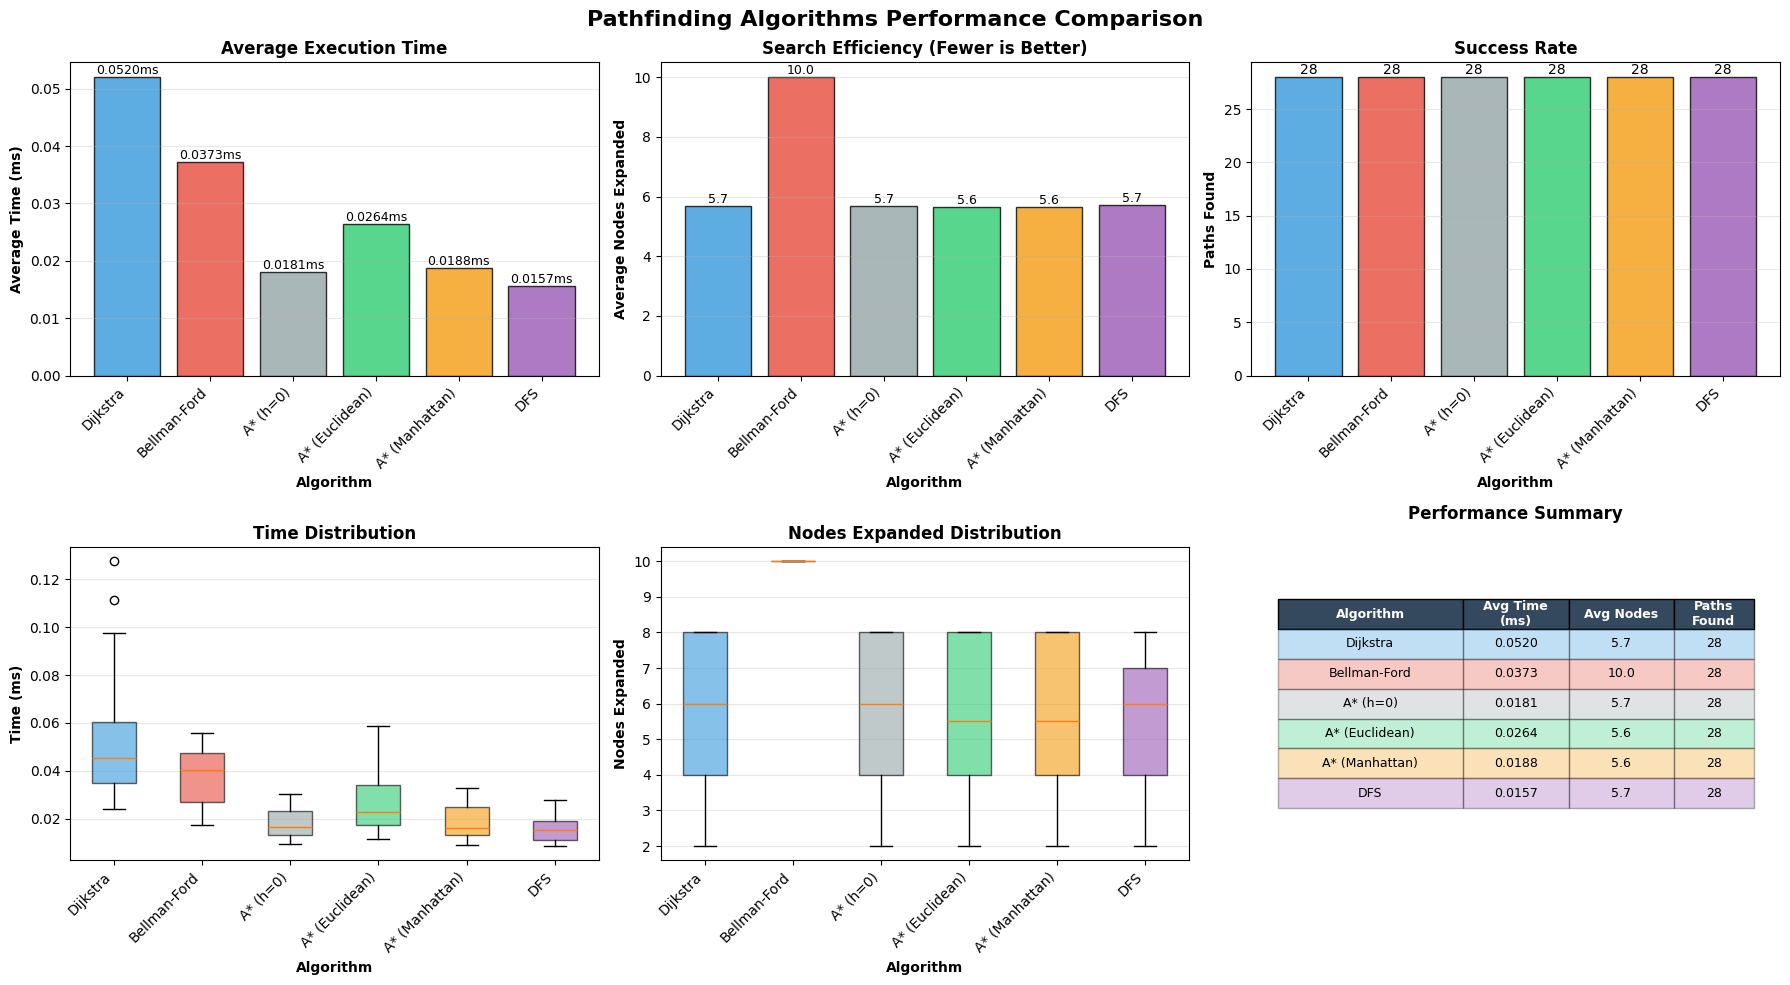


DETAILED PERFORMANCE STATISTICS

Dijkstra:
  Paths Found: 28
  Avg Time: 0.0520 ms
  Min Time: 0.0239 ms
  Max Time: 0.1276 ms
  Avg Nodes Expanded: 5.7
  Min Nodes Expanded: 2
  Max Nodes Expanded: 8

Bellman-Ford:
  Paths Found: 28
  Avg Time: 0.0373 ms
  Min Time: 0.0171 ms
  Max Time: 0.0557 ms
  Avg Nodes Expanded: 10.0
  Min Nodes Expanded: 10
  Max Nodes Expanded: 10

A* (h=0):
  Paths Found: 28
  Avg Time: 0.0181 ms
  Min Time: 0.0094 ms
  Max Time: 0.0301 ms
  Avg Nodes Expanded: 5.7
  Min Nodes Expanded: 2
  Max Nodes Expanded: 8

A* (Euclidean):
  Paths Found: 28
  Avg Time: 0.0264 ms
  Min Time: 0.0116 ms
  Max Time: 0.0587 ms
  Avg Nodes Expanded: 5.6
  Min Nodes Expanded: 2
  Max Nodes Expanded: 8

A* (Manhattan):
  Paths Found: 28
  Avg Time: 0.0188 ms
  Min Time: 0.0088 ms
  Max Time: 0.0326 ms
  Avg Nodes Expanded: 5.6
  Min Nodes Expanded: 2
  Max Nodes Expanded: 8

DFS:
  Paths Found: 28
  Avg Time: 0.0157 ms
  Min Time: 0.0085 ms
  Max Time: 0.0276 ms
  Avg Nodes E

In [11]:
import matplotlib.pyplot as plt
import time
from collections import defaultdict

# Test all algorithms and collect performance metrics
def benchmark_algorithms(graph, problem_size, node_positions):
    """Benchmark all pathfinding algorithms"""
    
    results = {
        'Dijkstra': {'times': [], 'nodes_expanded': [], 'paths_found': 0, 'total_cost': 0},
        'Bellman-Ford': {'times': [], 'nodes_expanded': [], 'paths_found': 0, 'total_cost': 0},
        'A* (h=0)': {'times': [], 'nodes_expanded': [], 'paths_found': 0, 'total_cost': 0},
        'A* (Euclidean)': {'times': [], 'nodes_expanded': [], 'paths_found': 0, 'total_cost': 0},
        'A* (Manhattan)': {'times': [], 'nodes_expanded': [], 'paths_found': 0, 'total_cost': 0},
        'DFS': {'times': [], 'nodes_expanded': [], 'paths_found': 0, 'total_cost': 0},
    }
    
    euclidean_h = euclidean_heuristic(node_positions)
    manhattan_h = manhattan_heuristic(node_positions)
    
    for s, d in combinations(range(problem_size), 2):
        # NetworkX reference
        try:
            nx_path = nx.shortest_path(G, s, d, weight='weight')
            nx_cost = nx.path_weight(G, nx_path, weight='weight')
        except nx.NetworkXNoPath:
            continue  # Skip pairs with no path
        
        # Test each algorithm
        algorithms = [
            ('Dijkstra', lambda: dijkstra_search(G, s, d, {}, {}), None),
            ('Bellman-Ford', lambda: bellman_ford_search(G, s, d, {}, {}), None),
            ('A* (h=0)', lambda ps={}, sc={}: a_star_search(G, s, d, ps, sc, heuristic=zero_heuristic), None),
            ('A* (Euclidean)', lambda ps={}, sc={}: a_star_search(G, s, d, ps, sc, heuristic=euclidean_h), None),
            ('A* (Manhattan)', lambda ps={}, sc={}: a_star_search(G, s, d, ps, sc, heuristic=manhattan_h), None),
            ('DFS', lambda: dfs_search(G, s, d, {}, {}), None),
        ]
        
        for name, algo_func, _ in algorithms:
            parent_state = {}
            state_cost = {}
            
            start_time = time.perf_counter()
            
            if 'A*' in name:
                if 'Euclidean' in name:
                    path, cost = a_star_search(G, s, d, parent_state, state_cost, heuristic=euclidean_h)
                elif 'Manhattan' in name:
                    path, cost = a_star_search(G, s, d, parent_state, state_cost, heuristic=manhattan_h)
                else:
                    path, cost = a_star_search(G, s, d, parent_state, state_cost, heuristic=zero_heuristic)
            elif name == 'Dijkstra':
                path, cost = dijkstra_search(G, s, d, parent_state, state_cost)
            elif name == 'Bellman-Ford':
                path, cost = bellman_ford_search(G, s, d, parent_state, state_cost)
            else:  # DFS
                path, cost = dfs_search(G, s, d, parent_state, state_cost)
            
            elapsed_time = time.perf_counter() - start_time
            
            if path is not None:
                results[name]['times'].append(elapsed_time * 1000)  # Convert to ms
                results[name]['nodes_expanded'].append(len(state_cost))
                results[name]['paths_found'] += 1
                results[name]['total_cost'] += cost
    
    return results

# Run benchmark
print("Running benchmark...")
results = benchmark_algorithms(G, problem.shape[0], node_positions)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Pathfinding Algorithms Performance Comparison', fontsize=16, fontweight='bold')

algorithms = list(results.keys())
colors = ['#3498db', '#e74c3c', '#95a5a6', '#2ecc71', '#f39c12', '#9b59b6']

# 1. Average execution time
ax1 = axes[0, 0]
avg_times = [np.mean(results[alg]['times']) if results[alg]['times'] else 0 for alg in algorithms]
bars1 = ax1.bar(range(len(algorithms)), avg_times, color=colors, alpha=0.8, edgecolor='black')
ax1.set_xlabel('Algorithm', fontweight='bold')
ax1.set_ylabel('Average Time (ms)', fontweight='bold')
ax1.set_title('Average Execution Time', fontweight='bold')
ax1.set_xticks(range(len(algorithms)))
ax1.set_xticklabels(algorithms, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}ms', ha='center', va='bottom', fontsize=9)

# 2. Average nodes expanded
ax2 = axes[0, 1]
avg_nodes = [np.mean(results[alg]['nodes_expanded']) if results[alg]['nodes_expanded'] else 0 for alg in algorithms]
bars2 = ax2.bar(range(len(algorithms)), avg_nodes, color=colors, alpha=0.8, edgecolor='black')
ax2.set_xlabel('Algorithm', fontweight='bold')
ax2.set_ylabel('Average Nodes Expanded', fontweight='bold')
ax2.set_title('Search Efficiency (Fewer is Better)', fontweight='bold')
ax2.set_xticks(range(len(algorithms)))
ax2.set_xticklabels(algorithms, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9)

# 3. Paths found (success rate)
ax3 = axes[0, 2]
paths_found = [results[alg]['paths_found'] for alg in algorithms]
bars3 = ax3.bar(range(len(algorithms)), paths_found, color=colors, alpha=0.8, edgecolor='black')
ax3.set_xlabel('Algorithm', fontweight='bold')
ax3.set_ylabel('Paths Found', fontweight='bold')
ax3.set_title('Success Rate', fontweight='bold')
ax3.set_xticks(range(len(algorithms)))
ax3.set_xticklabels(algorithms, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=10)

# 4. Time distribution (box plot)
ax4 = axes[1, 0]
time_data = [results[alg]['times'] for alg in algorithms if results[alg]['times']]
bp1 = ax4.boxplot(time_data, labels=algorithms, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax4.set_xlabel('Algorithm', fontweight='bold')
ax4.set_ylabel('Time (ms)', fontweight='bold')
ax4.set_title('Time Distribution', fontweight='bold')
ax4.set_xticklabels(algorithms, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 5. Nodes expanded distribution (box plot)
ax5 = axes[1, 1]
nodes_data = [results[alg]['nodes_expanded'] for alg in algorithms if results[alg]['nodes_expanded']]
bp2 = ax5.boxplot(nodes_data, labels=algorithms, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax5.set_xlabel('Algorithm', fontweight='bold')
ax5.set_ylabel('Nodes Expanded', fontweight='bold')
ax5.set_title('Nodes Expanded Distribution', fontweight='bold')
ax5.set_xticklabels(algorithms, rotation=45, ha='right')
ax5.grid(axis='y', alpha=0.3)

# 6. Summary statistics table
ax6 = axes[1, 2]
ax6.axis('tight')
ax6.axis('off')

summary_data = []
for alg in algorithms:
    avg_time = np.mean(results[alg]['times']) if results[alg]['times'] else 0
    avg_nodes = np.mean(results[alg]['nodes_expanded']) if results[alg]['nodes_expanded'] else 0
    success = results[alg]['paths_found']
    summary_data.append([
        alg,
        f"{avg_time:.4f}",
        f"{avg_nodes:.1f}",
        f"{success}"
    ])

table = ax6.table(cellText=summary_data,
                  colLabels=['Algorithm', 'Avg Time\n(ms)', 'Avg Nodes', 'Paths\nFound'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.35, 0.2, 0.2, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color rows
for i, color in enumerate(colors):
    for j in range(4):
        table[(i+1, j)].set_facecolor(color)
        table[(i+1, j)].set_alpha(0.3)

ax6.set_title('Performance Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("DETAILED PERFORMANCE STATISTICS")
print("="*80)
for alg in algorithms:
    print(f"\n{alg}:")
    print(f"  Paths Found: {results[alg]['paths_found']}")
    if results[alg]['times']:
        print(f"  Avg Time: {np.mean(results[alg]['times']):.4f} ms")
        print(f"  Min Time: {np.min(results[alg]['times']):.4f} ms")
        print(f"  Max Time: {np.max(results[alg]['times']):.4f} ms")
    if results[alg]['nodes_expanded']:
        print(f"  Avg Nodes Expanded: {np.mean(results[alg]['nodes_expanded']):.1f}")
        print(f"  Min Nodes Expanded: {np.min(results[alg]['nodes_expanded'])}")
        print(f"  Max Nodes Expanded: {np.max(results[alg]['nodes_expanded'])}")
print("="*80)